# Use CNN to detect if an image has a happy or sad face

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import subprocess
import zipfile
import random
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## Load and explore data

In [2]:
## Create a folder to download our data
data_folder = 'data'
if not os.path.exists(data_folder):
    print("Creating data folder...")
    os.mkdir(data_folder)
    
## Download data
download_command = '''wget \
--no-check-certificate \
https://storage.googleapis.com/laurencemoroney-blog.appspot.com/happy-or-sad.zip \
-O data/happy-or-sad.zip'''

if not os.path.exists(data_folder + '/happy-or-sad.zip'):
    print("Downloading data...")
    os.system(download_command)

In [3]:
## Unzip
zip_ref = zipfile.ZipFile(data_folder + '/happy-or-sad.zip','r')
zip_ref.extractall('data/happy-or-sad')
zip_ref.close()

Sub-folders labeled `humans` and `horses` have been created. This will be useful later on when using `ImageGenerator`

In [4]:
train_happy_dir = os.path.join(data_folder + '/happy-or-sad/happy')
train_sad_dir = os.path.join(data_folder + '/happy-or-sad/sad')

train_happy_names = os.listdir(train_happy_dir)
print(train_happy_names[:3])

train_sad_names = os.listdir(train_sad_dir)
print(train_sad_names[:3])

print('total training happy images:', len(os.listdir(train_happy_dir)))
print('total training sad images:', len(os.listdir(train_sad_dir)))

['happy2-01.png', 'happy1-08.png', 'happy1-18.png']
['sad2-06.png', 'sad2-02.png', 'sad1-09.png']
total training happy images: 40
total training sad images: 40


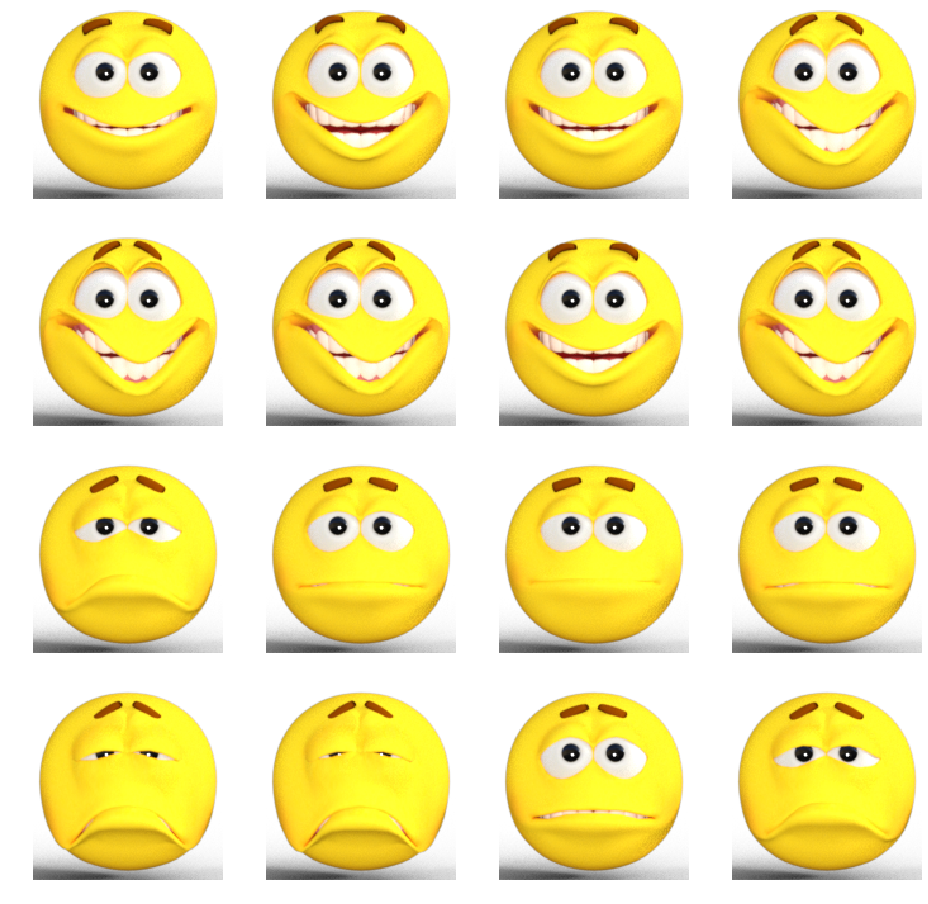

In [5]:
nrows = 4
ncols = 4
pic_index = 1

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows *4)

pic_index +=8
next_happy_pix = [os.path.join(train_happy_dir, fname)
                  for fname in train_happy_names[pic_index-8:pic_index]]
next_sad_pix = [os.path.join(train_sad_dir, fname)
                  for fname in train_sad_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_happy_pix+next_sad_pix):
    sp = plt.subplot(nrows, ncols, i+1)
    sp.axis('Off')
    
    img = mpimg.imread(img_path)
    plt.imshow(img)
    
plt.show()

## Build the CNN
5 CNNs and a NN at the end

In [6]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
    ## Flatten
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid') 
])

model.summary()

W0705 10:44:27.741611 139826575472448 deprecation.py:506] From /home/elder/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

In [7]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.001),
              loss = 'binary_crossentropy',
              metrics = ['acc'])

W0705 10:44:27.868072 139826575472448 deprecation.py:323] From /home/elder/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Data Preprocessing
The data generator will read pictures directly from the source folders, convert them to tensors, and feed them with labels to our NN.

In [8]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.)

# Pass training images in batches of 128
train_generator = train_datagen.flow_from_directory('data/happy-or-sad/',
                                                   target_size=(150,150),
                                                   batch_size=128,
                                                   class_mode='binary')


Found 80 images belonging to 2 classes.


## Training

In [9]:
class myCallback(tf.keras.callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('acc') > 0.999:
            print("\nReached 99.9% accuracy, interrupting training!")
            self.model.stop_training = True
            
callbacks = myCallback()

history = model.fit_generator(train_generator,
                              steps_per_epoch=8,
                              epochs=100,
                              callbacks=[callbacks],
                              verbose=1,
                             )

Epoch 1/100
8/8 [==============================] - 3s 316ms/step - loss: 1.1265 - acc: 0.6266
Epoch 2/100
8/8 [==============================] - 1s 101ms/step - loss: 0.1829 - acc: 0.9469
Epoch 3/100
8/8 [==============================] - 1s 103ms/step - loss: 0.0956 - acc: 0.9719
Epoch 4/100
8/8 [==============================] - 1s 103ms/step - loss: 0.0478 - acc: 0.9812
Epoch 5/100
8/8 [==============================] - 1s 103ms/step - loss: 0.0211 - acc: 0.9969
Epoch 6/100
7/8 [=========================>....] - ETA: 0s - loss: 0.0059 - acc: 1.0000
Reached 99.9% accuracy, interrupting training!
8/8 [==============================] - 1s 103ms/step - loss: 0.0057 - acc: 1.0000


## Test the model

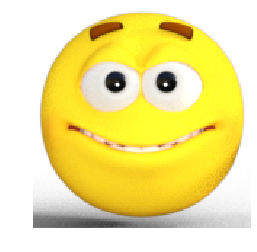

(150, 150, 3)
(1, 150, 150, 3)
[[7.110279e-06]]
data/happy-or-sad/happy/happy1-06.png is a happy


In [10]:
img_path = 'data/happy-or-sad/happy/happy1-06.png'

img = mpimg.imread(img_path)
plt.imshow(img)
plt.axis('off')
plt.show()

img_happy = tf.keras.preprocessing.image.load_img(img_path, target_size=(150,150))
x = tf.keras.preprocessing.image.img_to_array(img_happy)
x /= 255.
print(x.shape)
x = np.expand_dims(x, axis=0)
print(x.shape)
## This is if we had multiple images
images = np.vstack([x])

## Run the model
classes = model.predict(images,batch_size=10)
print(classes)

if classes[0]>0.5:
    print(img_path + " is a sad")
else:
    print(img_path + " is a happy")

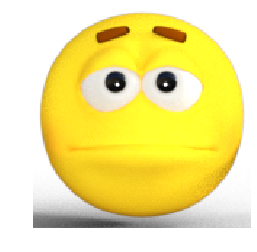

(150, 150, 3)
(1, 150, 150, 3)
[[0.98181987]]
data/happy-or-sad/sad/sad1-06.png is a sad


In [11]:
img_path = 'data/happy-or-sad/sad/sad1-06.png'

img = mpimg.imread(img_path)
plt.imshow(img)
plt.axis('off')
plt.show()

img_happy = tf.keras.preprocessing.image.load_img(img_path, target_size=(150,150))
x = tf.keras.preprocessing.image.img_to_array(img_happy)
x /= 255.
print(x.shape)
x = np.expand_dims(x, axis=0)
print(x.shape)
## This is if we had multiple images
images = np.vstack([x])

## Run the model
classes = model.predict(images,batch_size=10)
print(classes)

if classes[0]>0.5:
    print(img_path + " is a sad")
else:
    print(img_path + " is a happy")

## Visualize Intermediate Represnatation
Let's look at how the input image is transformed as it goes through the convolutional NN.

Each row corresponds to the output of a layer, and each image in the row is a specific convolution in the output feature map.

In [12]:
## Let's define a model that will take an image as input, and will
## output intermediate representations
succesive_outputs = [layer.output for layer in model.layers]

visualization_model = tf.keras.models.Model(inputs = model.input,
                                            outputs = succesive_outputs)

## Let's grab a random input image
happy_image_files = [os.path.join(train_happy_dir, f) for f in train_happy_names]
sad_image_files = [os.path.join(train_sad_dir, f) for f in train_sad_names]

def DrawIntermediateRepresentation():

    random_img = random.choice(happy_image_files+sad_image_files)

    img = tf.keras.preprocessing.image.load_img(random_img, target_size=(150,150))
    x = tf.keras.preprocessing.image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    
    ## Rescale
    x /= 255.

    sucessive_feature_maps = visualization_model.predict(x)

    ## Get layer names before we loop them
    layer_names = [layer.name for layer in model.layers]

    ## And now loop
    for layer_name, feature_map in zip(layer_names, sucessive_feature_maps):
    
        ## Only deal with conv and maxpooling layers
        ## not fully connected layers
        ## The feature map has shape (1, size, size, n_features)
        if len(feature_map.shape) == 4:
            n_features = feature_map.shape[-1]
            size = feature_map.shape[1]
            display_grid = np.zeros((size, size*n_features))
        
            for i in range(n_features):
                ## Get the image
                x = feature_map[0,:,:,i]
                ## Do some postprocessing
                x -= x.mean()
                x /= x.std()
                x *=64
                x += 128
                x = np.clip(x, 0, 255).astype('uint8')
            
                ## And then each conv goes into the grid
                display_grid[:,i*size:(i+1)*size] = x
        
            ## Display the grid
            scale = 20./n_features
            plt.figure(figsize=(scale*n_features, scale))
            title_name = layer_name,'has',n_features,'features'
            plt.title(title_name)
            plt.grid(False)
            plt.imshow(display_grid, aspect='auto', cmap='viridis')

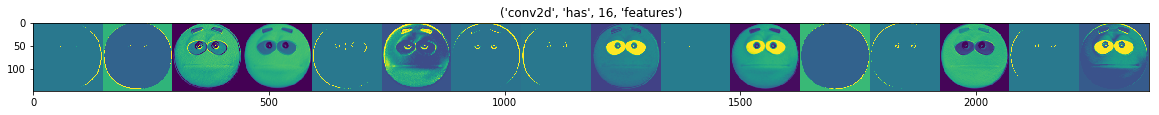

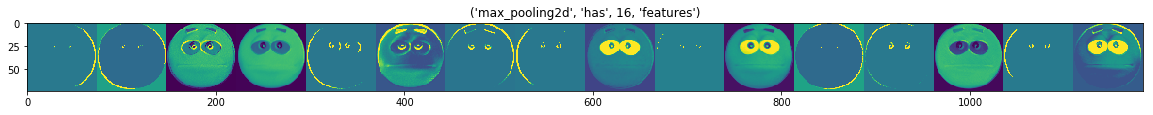

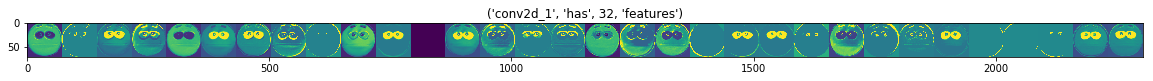

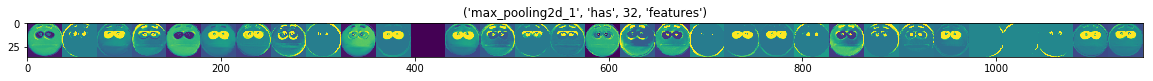

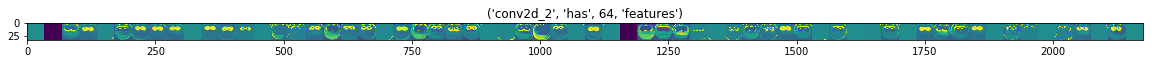

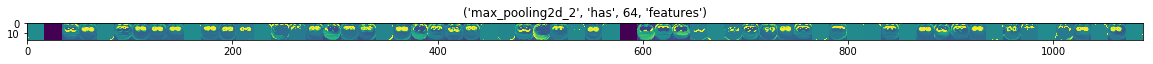

In [13]:
DrawIntermediateRepresentation()

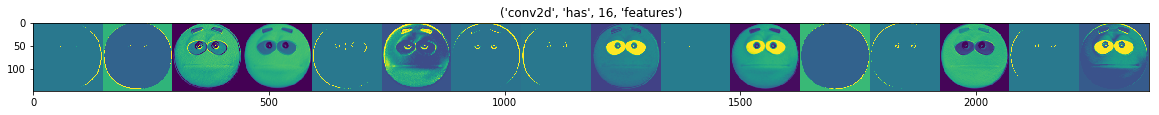

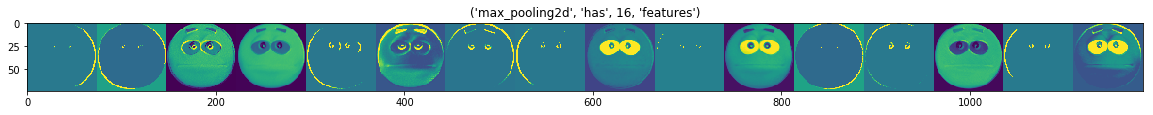

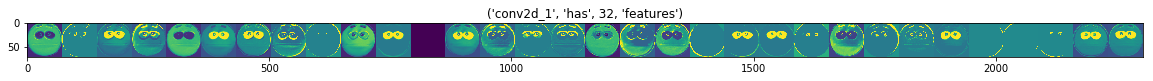

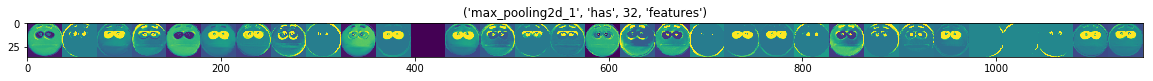

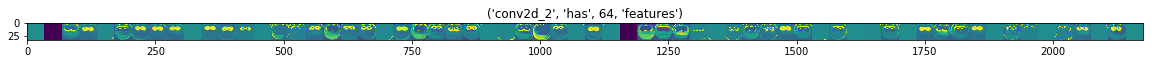

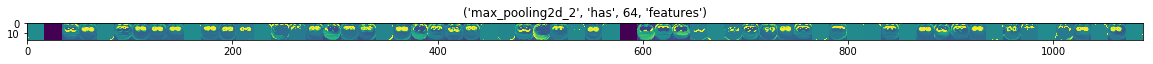

In [14]:
DrawIntermediateRepresentation()